# Prophecy of Properties: Exploring The Housing Market in Cook County

<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />

## Introduction

#### This project follows the Data Science Lifecycle as it explores what can be learned from an extensive housing dataset that is embedded in a dense social context in Cook County, Illinois.
* Some of this code takes reference from Sherry Fan, notably `bin_col`

##### Import Statements

In [401]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

from pandas.api.types import CategoricalDtype

from sklearn import linear_model as lm

from ds100_utils import *

from sklearn.preprocessing import OneHotEncoder

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Housing Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which we will try and predict with Ordinary Least Squares regression. An explanation of each variable can be found in the included `codebook.txt` file (you can optionally open this by first clicking the `data` folder, then clicking `codebook.txt` file in the navigation pane).

I have split the data into training and testing sets with 204,792 and 68,264 observations, respectively.

Let's first extract the data from the `cook_county_data.zip`. I decided to not leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [402]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

Let's load the initial data.

In [403]:
initial_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [404]:
# 204,792 observations and 62 features in training data
assert initial_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in initial_data.columns.values

##### No Errors means we're good to go!

Let's try and get a feel for the variables in our data.  A more detailed description of each variable is included in `codebook.txt`

Let's take a quick look at all the current columns in our initial data.

In [405]:
initial_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

This is the first entry in the `Description` Column:

In [406]:
initial_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Contextualizing the Data
Let's consider the background of our dataset before diving into a full-scale analysis. 

<!-- BEGIN QUESTION -->

### 1) Granuarity of the Data (i.e. What does each row represent?)

Each row represents the sale of one house. Specifically, the sale of a house in Cook County, where our data is from. 


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---
### 2) What are some possible explanations for why this data was collected? What purposes could they serve? Who collected it?

This data could just be financial records of all the houses, and could have been used to keep track of current market rates for the sale of houses in certain locations. The data could also have been collected in order to keep track of financial records, so for any house, you could see how its value changed throughout time. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---
### 3) Given this data, what are some initial questions we could go about answering?

##### "How has the average price of each house changed throughout time?" 
* We could make a line plot which time on the X axis, and the mean price on the y axis, using column of `Sale Price`. 

* One other thing we could do is a create a heatmap of the cook county area, and see how the mean `Sale Price` price differs for certain neighborhoods. We could do something with geopandas in that case.

* The specific column we would work with would probably be the `Neighborhood` code. If we had more data on what the latitudes and longitudes of each code was, then we would be able to answer this question.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. 

For simplicity, we will perform EDA on the **initial data**.

### Sale Price
We begin by examining the distribution of our target variable `Sale Price`. We defined the helper method `plot_distribution` to make it easier to visualize the distribution of the `Sale Price` using both a histogram and box plot at the same time.

In [407]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

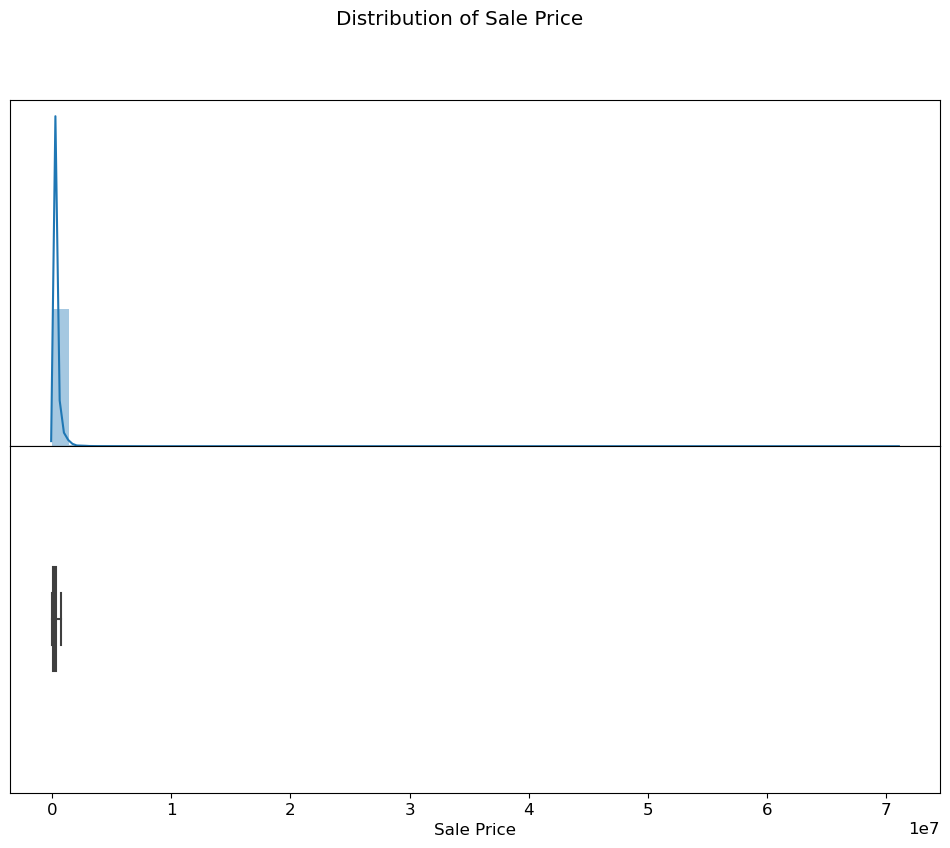

In [408]:
plot_distribution(initial_data, label='Sale Price')

At the same time, we also take a look at some descriptive statistics of this variable. Run the following cell.

In [409]:
initial_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

<!-- BEGIN QUESTION -->

Using both the plots and the statistics from `initial_data['Sale Price'].describe()`, we run into the following issue: 

* Most of our data seems to be clustered around a very small area, while the presence of very large outliers skew our whole graph. 

* Thus, the scaling is off. 
* Since these large outliers are so big, but their abundance is so little, it's hard to see the distribution of the data which is of the **majority**. 
* It's almost impossible to see the true distribution of most of our data. 
* In order to combat this, we could scale all of our datapoints so that the outliers are much closer to the rest of our data. 
* One process could be taking the log of each datapoint, thus making the large values align more with the others. 

<br><br>

---

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price`. In addition, it may be a good idea to apply a log transformation to `Sale Price`. In the cell below, we assigned `training_data` to a new `DataFrame` that is the same as `initial_data` **except with the following changes**:

- `training_data` contains only households whose price is at least $500.
- `training_data` contains a new `Log Sale Price` column that contains the log-transformed sale prices.

**Note**: This also implies from now on, our target variable in the model will be the log-transformed sale prices from the column `Log Sale Price`. 

In [410]:
at_least_500 = initial_data[initial_data["Sale Price"] >= 500] 
log_transformed = np.log(at_least_500["Sale Price"])
training_data = at_least_500
training_data["Log Sale Price"] = log_transformed
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,1.0,3.0,...,2,1.0,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925


Let's create a new distribution plot using the log-transformed sale prices. We observe that the distribution for `Log Scale Price` is much more uniform.

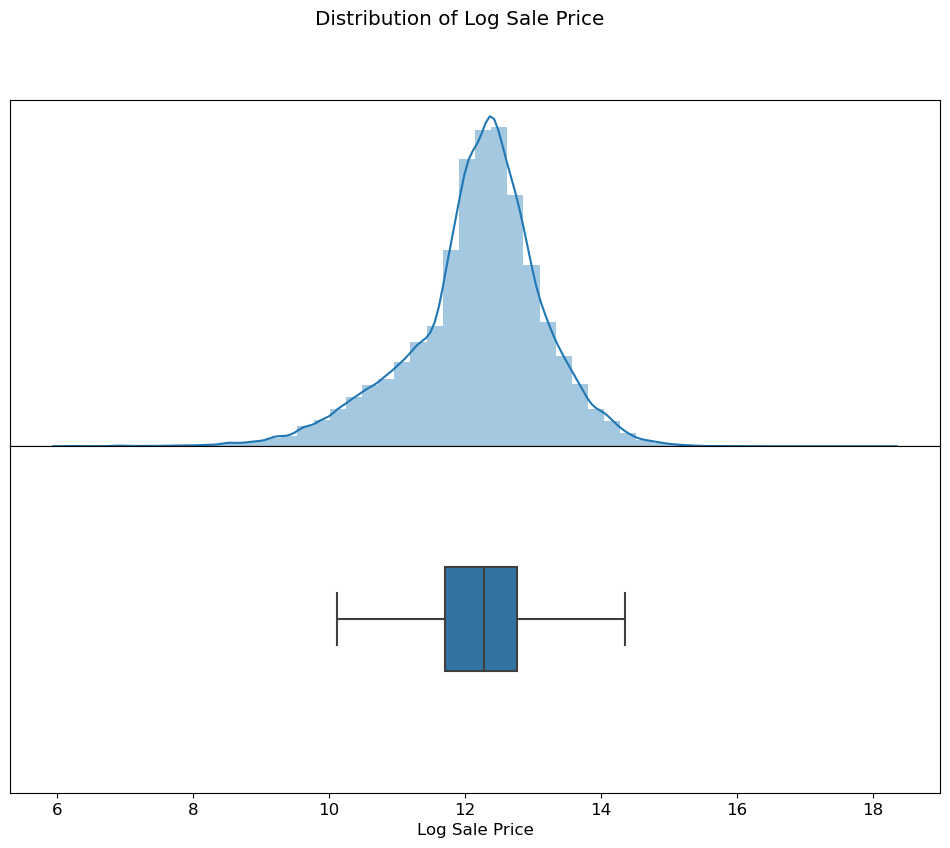

In [411]:
plot_distribution(training_data, label='Log Sale Price');

<br><br>

---

A reasonable question is to ask "Is there any correlation between `Log Sale Price` and the total area occupied by the property?" Referencing `codebook.txt`, it tells us that the column `Building Square Feet` should do the trick — it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, we create a new column `Log Building Square Feet` in our `training_data` that contains the log-transformed area occupied by each property. 

In [412]:
training_data['Log Building Square Feet'] = np.log(training_data["Building Square Feet"])

<!-- BEGIN QUESTION -->

<br><br>

---

In the visualization below, we created a `jointplot` with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, we can see that `Log Building Square Feet` would make a good candidate as one of the features for our model, as there is a fairly strong, linear correlation between `Log Building Square Feet` and `Log Sale Price`


![Joint Plot](images/q2p3_jointplot.png)


<!-- END QUESTION -->

---

To prevent running into into more outliers which prevent us from creating a clear visualization / capturing the trend of the majority of the houses, we wrote a function called `remove_outliers`

`remove_outliers` removes outliers from the dataset based on a threshold value of a variable. For example, `remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)` would return a copy of `data` with only observations that satisfy `Building Square Feet` less than or equal to 8000 (inclusive) and `Building Square Feet` greater than 500 (inclusive).

In [413]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] >= lower) & (data[variable] <= upper)]

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

In this section, we go through a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. The `Bedrooms` column doesn't actually exist in the original `DataFrame`! Instead, it is part of the `Description` column.

In [414]:
# optional cell for scratch work
for i in np.arange(5):
    print (initial_data["Description"][i])

This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.
This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.


<br><br>

---

We create a `add_total_bedrooms(data)` function that returns a copy of `data` with an additional column called `Bedrooms`, which contains the total number of bedrooms (**as integers**) for each house. We treat missing values as zeros, if necessary.

In [415]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    pattern = r"(\d+) of which are bedrooms"
    with_rooms["Bedrooms"] = with_rooms["Description"].str.extract(pattern).astype("int")
    return with_rooms

training_data = add_total_bedrooms(training_data)

<!-- BEGIN QUESTION -->

<br><br>

---

Let's now create a visualization that clearly and succinctly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. Ideally, a good visualization should satisfy the following requirements:
- It should avoid overplotting.

- It should have clearly labeled axes and a succinct title.
- It should convey the strength of the correlation between `Sale Price` and the number of rooms: in other words, we should be able to look at the plot and describe the general relationship between `Log Sale Price` and `Bedrooms`.

Let's try plotting a boxplot *for each* discrete value of `Bedrooms`, just so we can get an idea of the variability among each `Bedrooms` value!

Text(0.5, 1.0, 'The Relationship Between Log Sale Price For Each Value Of Bedrooms')

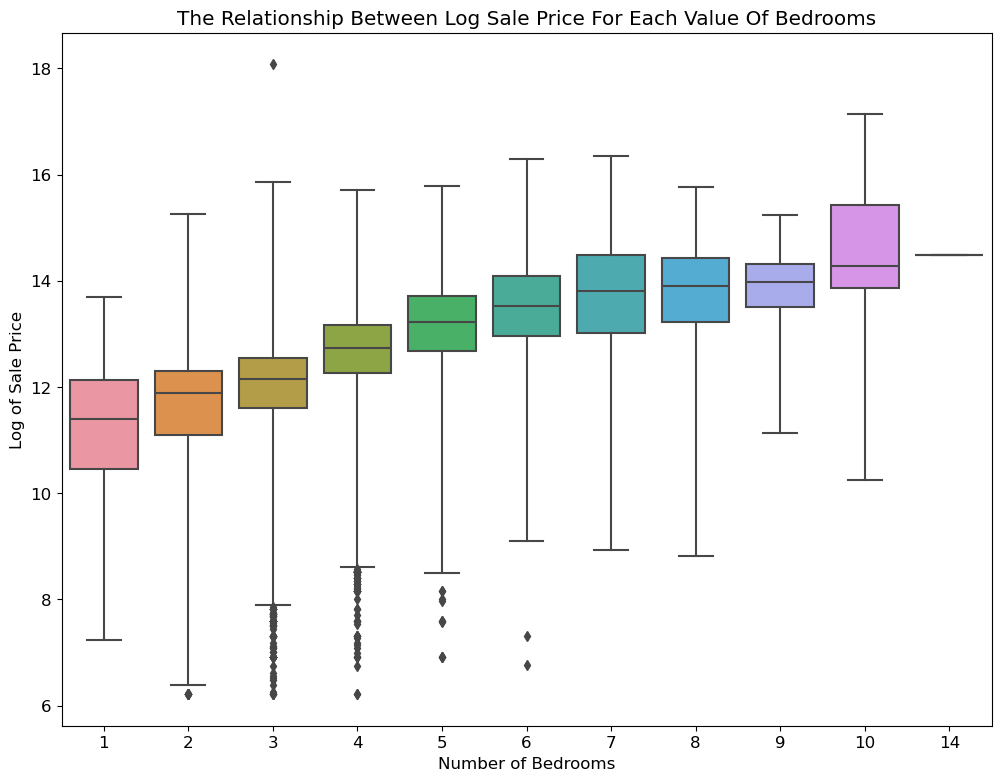

In [416]:
sns.boxplot(x = training_data["Bedrooms"], y = training_data["Log Sale Price"], whis = 4)
plt.xlabel("Number of Bedrooms")
plt.ylabel("Log of Sale Price")
plt.title("The Relationship Between Log Sale Price For Each Value Of Bedrooms")

<!-- END QUESTION -->

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our dataset.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column, `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

<br><br>

---
If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we get the following visualization.


![overplot](images/q5p2_catplot.png)


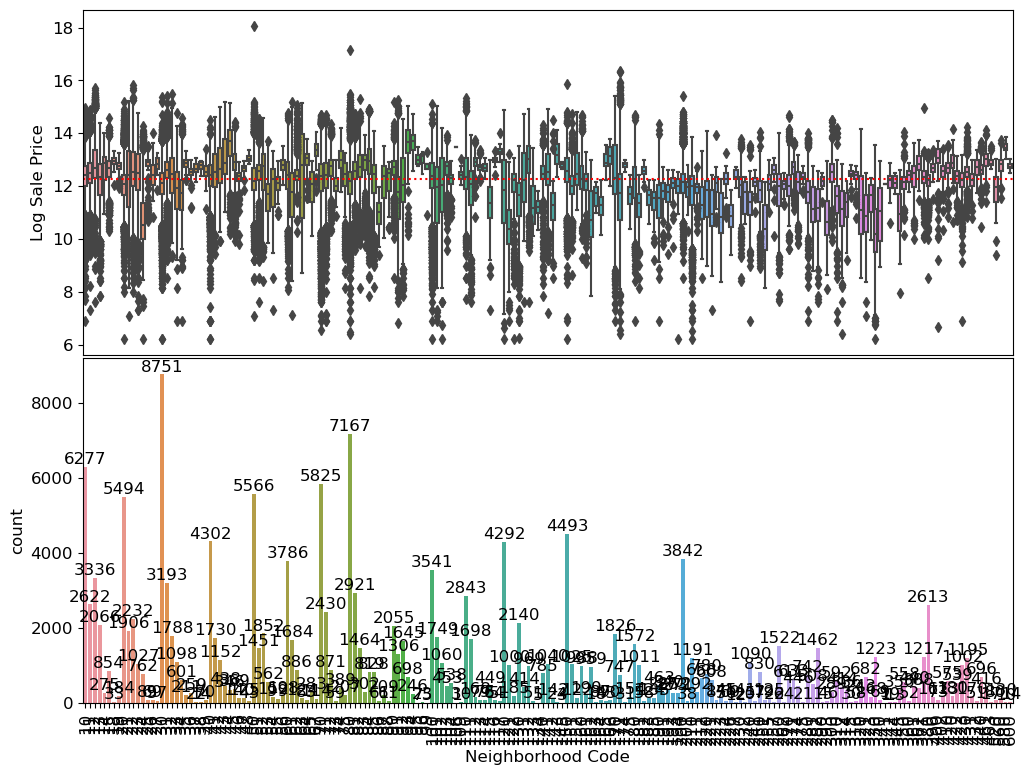

In [417]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

plot_categorical(training_data)

Oh no, looks like we have run into the problem of overplotting again! 

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Let's create `in_top_20_neighborhoods`, a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are in one of the top 20 most populous neighborhoods. We define the top 20 neighborhoods as being the 20 neighborhood codes that have the greatest number of properties within them.

In [418]:
top_20_neighborhood_codes = training_data["Neighborhood Code"].value_counts().head(20).index.tolist()
in_top_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(top_20_neighborhood_codes)]
in_top_20_neighborhoods

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2
8,13232040260000,205,70,3100.0,71,0.0,2.0,2.0,1.0,3.0,...,10.0,1,1.0,70,7170,"This property, sold on 08/25/2016, is a two-st...",3100.0,13.422468,7.636270,4
10,19074270080000,202,380,3750.0,72,0.0,1.0,1.0,2.0,3.0,...,7.4,1,1.0,380,72380,"This property, sold on 05/01/2017, is a one-st...",3750.0,11.695247,6.841615,2
11,15083050330000,203,20,5092.0,31,0.0,2.0,1.0,1.0,1.0,...,5.8,1,1.0,20,3120,"This property, sold on 04/29/2014, is a one-st...",5092.0,11.184421,6.911747,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204781,20361190390000,203,80,4405.0,70,0.0,2.0,1.0,1.0,3.0,...,5.7,1,1.0,80,7080,"This property, sold on 07/15/2013, is a one-st...",4405.0,10.913269,7.141245,3
204785,9284030280000,202,40,6650.0,22,0.0,1.0,1.0,1.0,3.0,...,6.1,1,1.0,40,2240,"This property, sold on 04/03/2014, is a one-st...",6650.0,11.736069,6.761573,3
204786,8141120110000,203,100,10010.0,16,0.0,2.0,1.0,1.0,1.0,...,5.6,1,1.0,100,16100,"This property, sold on 09/08/2016, is a one-st...",10010.0,12.568978,6.948897,3
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,1.0,3.0,...,6.0,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0,12.879017,7.092574,3


Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

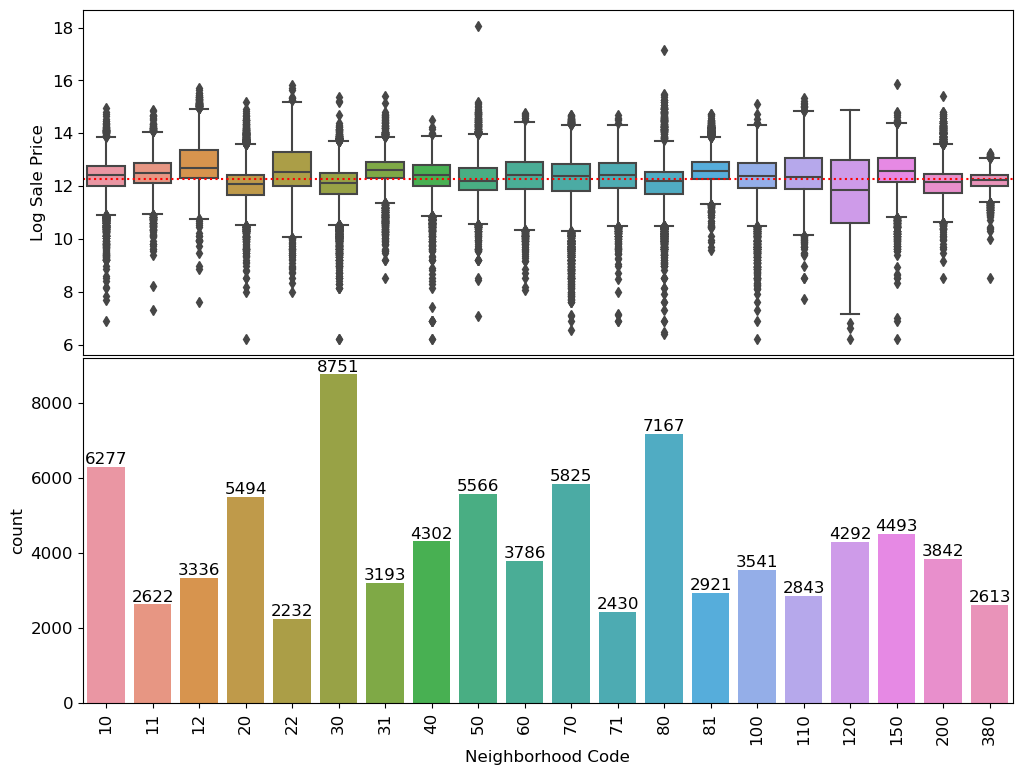

In [419]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

<br><br>

---

From the plot above, we can see that there is much less data available for some neighborhoods. For example, Neighborhood 71 has only around 27% of the number of datapoints as Neighborhood 30.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together. We’ll categorize our neighborhoods in a crude way. In this question, we’ll compute how “expensive” each neighborhood is by aggregating the `Log Sale Price`s for all properties in a particular neighborhood using a `metric`, such as the median. We’ll use this `metric` to find the top `n` most expensive neighborhoods. Later, we’ll label these “expensive neighborhoods” and leave all other neighborhoods unmarked.

Fill in `find_expensive_neighborhoods` to return a **list** of the neighborhood codes of the **top `n`** most expensive neighborhoods as measured by our choice of `metric`.

For example, calling `find_expensive_neighborhoods(training_data, n=3, metric=np.median)` should return the 3 neighborhood codes with the highest median `Log Sale Price` computed across all properties in those neighborhood codes. 

In [420]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least an int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = data[["Neighborhood Code", "Log Sale Price"]].groupby("Neighborhood Code").agg(metric)
    sorted = neighborhoods.sort_values("Log Sale Price", ascending = False)
    neighborhoods = sorted.head(n).index.tolist()
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in NumPy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

<br><br>

---

We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write an additional function `add_expensive_neighborhood` that takes in a `DataFrame` of housing data (`data`) and a list of neighborhood codes considered to be expensive (`expensive_neighborhoods`). You can think of `expensive_neighborhoods` as being the output of the function `find_expensive_neighborhoods`. 

Using these inputs, `add_expensive_neighborhood` should add a column to `data` named `in_expensive_neighborhood` that takes on the **integer** value of 1 if a property is part of a neighborhood in `expensive_neighborhoods` and the integer value of 0 if it is not. This type of variable is known as an **indicator variable**.

In [421]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      expensive_neighborhoods (list of ints): ints should be the neighborhood codes of
        neighborhoods pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype("int")
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

Let's take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

<br><br>

---

If we look at `codebook.txt` carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Roof Material (Nominal): 

       1    Shingle/Asphalt
       2    Tar & Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other
```

We defined the function `substitute_roof_material` which replaces each numerical value in `Roof Material` with their corresponding roof material. The function returns a new `DataFrame`, and doesn't modify the existing `DataFrame`.

In [422]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      new DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    new_data = data.copy()
    new_data = new_data.replace({"Roof Material":{1.0:"Shingle/Asphalt", 2.0:"Tar & Gravel", 3.0:"Slate", 4.0:"Shake", 5.0:"Tile", 6:"Other"}})
    return new_data
    
training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


<br><br>

---

#### An Important Note on One-Hot-Encoding 

Unfortunately, simply replacing the integers with the appropriate strings isn’t sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data. For more information on why we want to use one-hot-encoding.

The function `ohe_roof_material` returns a `DataFrame` with the new column one-hot-encoded on the roof material of the household. These new columns have the form `Roof Material_MATERIAL`, returning a new `DataFrame`. 

Here, we use `scikit-learn`’s `OneHotEncoder` to perform the one-hot-encoding. `OneHotEncoder` will automatically generate column names of the form `Roof Material_MATERIAL`. We wish to construct the one-hot-encoding columns **without removing any columns**.

In [423]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    column = ["Roof Material"]

    encoder = OneHotEncoder()
    fitted = encoder.fit(data[column])
    transformed = fitted.transform(data[column]).toarray()

    transformed_df = pd.DataFrame(data = transformed, columns = encoder.get_feature_names_out(), index = data.index)
    final = data.join(transformed_df)
    return final

training_data_ohe = ohe_roof_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


#### Now let's focus on building a linear regression model to predict house prices!

# Predicting Housing Prices in Cook County



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

In [424]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

#from ds100_utils import *
#from feature_func import *

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training, validation, and test data.

This dataset is split into a training set, a validation set, and a test set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project, we will train a model on the training and validation sets and then use this model to predict the `Sale Price`s of the test set. In the cell below, we load the training and validation sets into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [425]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the shape of the data matches the description.

In [426]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

<!-- END QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## Preparing Data


Let's split the dataset into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, the function `train_val_split` splits `data` into two smaller `DataFrame`s named `train` and `validation`. `train` contains 80% of the data, and `validation` contains the remaining 20%.

In [427]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general.

training_val_data = pd.read_csv("cook_county_train_val.csv")

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    eighty_percent = int(data_len * 0.8)
    train = data.iloc[shuffled_indices[:eighty_percent]]
    validation = data.iloc[shuffled_indices[eighty_percent:]]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<br>

<hr style="border: 1px solid #fdb515;" />

## Fitting a Simple Model

Let's fit our linear regression model using the ordinary least squares estimator! We will start with something simple by using only two features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our first linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a second model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br>

--- 

##

**Without running any calculation or code**, assign `q3a` to be the comparator ('>=', '=', '<=') that fills the blank in the following statement:

We quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the first model and the training loss of the second model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model} ~~ \geq ~~ \text{Training Loss of the 2nd Model}
$$

This is because the second model is more complex

<br>

### Pipeline Function

Before, we wrote a few functions that added features to the dataset. Instead of calling them manually one by one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, we combined some functions into a single helper function that outputs `X` and `Y` for the first model above. Try to understand what this function does! 

In [428]:

def log_transform(data, col):
    data["Log " + col] = np.log(data[col])
    return data

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] >= lower) & (data[variable] <= upper)]

def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    pattern = r"(\d+) of which are bedrooms"
    with_rooms["Bedrooms"] = with_rooms["Description"].str.extract(pattern).astype("int")
    return with_rooms


###### Copy any function you would like to below ######
...
#######################################################


def feature_engine_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedroom column
    data = add_total_bedrooms(data)
    # Select X and Y from the full data
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = feature_engine_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = feature_engine_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we can build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `feature_engine_pipe` takes in a `DataFrame` `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [429]:
# Run this cell to define feature_engine_pipe; no further action is needed.
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

<br>

--- 

It is time to prepare the training and validation data for the two models we proposed above. The following two cells reload a fresh dataset from scratch and runs them through the following preprocessing steps using `feature_engine_pipe` for each model:

- Performs a `train_val_split` on the original dataset, loaded as the `DataFrame` `full_data`. Let 80% of the set be training data, and 20% of the set be validation data. 
- For both the training and validation set, we will 
    1. Remove outliers in `Sale Price` so that we consider households with a price that is greater than 499 dollars (or equivalently, a price that is 500 dollars or greater). 
    
    2. Apply log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` if this is the second model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`.

We also assigned the final training data and validation data for both models to the following set of variables:

- First Model: `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`.


- Second Model: `X_train_m2`, `Y_train_m2`, `X_valid_m2`, `Y_valid_m2`.


As a refresher, the equations model 1 and model 2, respectively, are:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [430]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Apply feature engineering to the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, Y_train_m1 = feature_engine_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = feature_engine_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [431]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': "Building Square Feet"}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', "Log Building Square Feet"], None)
]

X_train_m2, Y_train_m2 = feature_engine_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = feature_engine_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

,Bedrooms,Log Building Square Feet
130829,4,7.870166
193890,2,7.002156
30507,2,6.851185
91308,2,7.228388
131132,3,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

<br>

--- 

##

Finally, let's do some regression!

We first initialize a `sklearn.linear_model.LinearRegression` object [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [432]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. The cell below fits both models and then uses it to compute the fitted values of `Log Sale Price` over the training data and the predicted values of `Log Sale Price` for the validation data.

The predicted values from both of your models on the training and validation have been set to the following variables:

- First Model: predicted values on **training set**: `Y_fitted_m1`, predicted values on **validation set**: `Y_predicted_m1`

- Second Model: predicted values on **training set**: `Y_fitted_m2`, predicted values on **validation set**: `Y_predicted_m2`


In [433]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

<br>

<hr style="border: 1px solid #fdb515;" />

## Evaluate Our Simple Model

<br>

--- 

Let's now move into the analysis of our two models!

In [434]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br>

--- 

One way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.

In the cell below, we use `plt.scatter` [(documentation)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the second model** against the original `Log Sale Price` for the **validation data**. With such a large dataset, it is difficult to avoid overplotting entirely.

Text(0.5, 1.0, 'Residual Plot between Validation Log Sale Price and Log Sale Price For Model 2')

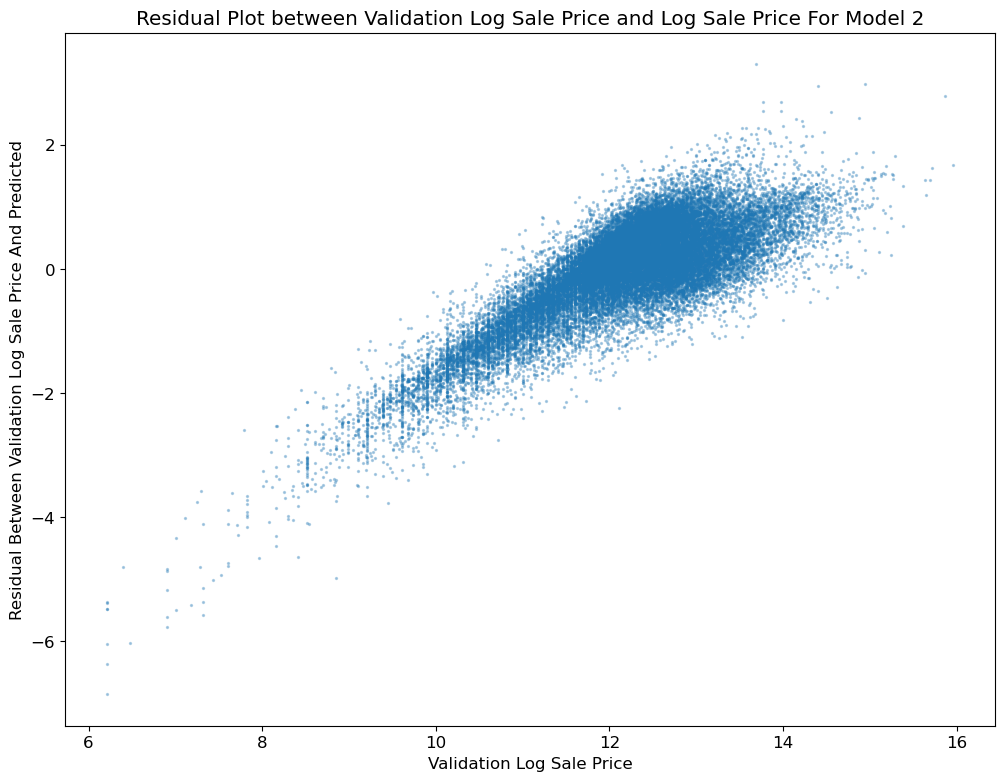

In [435]:
plt.scatter(Y_valid_m2, Y_valid_m2 - Y_predicted_m2, s = 2, alpha = 0.3);
plt.xlabel("Validation Log Sale Price")
plt.ylabel("Residual Between Validation Log Sale Price And Predicted")
plt.title("Residual Plot between Validation Log Sale Price and Log Sale Price For Model 2")
        

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement —— one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far!

<br>

<hr style="border: 1px solid #fdb515;" />

It is time to build a different model!

In the next few cells, we will conduct feature engineering on the training data using the `feature_engine_final` function, fit the model with this training data, and compute the training Root Mean Squared Error (RMSE). Then, we will process our test data with `feature_engine_final`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

Our goals in the following section are to:

* Define a function to perform feature engineering and produce a design matrix for modeling.

* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses.
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that our test set does not contain the true `Sale Price` of each house –— your model is trying to guess them! 


<br>

---

## Finding Potential Features

Building Square Feet, Roof Material, Age, Bedrooms

<br>

---

## More EDA

<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas. </summary>
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers? This can inform how you engineer your features later on.

* Make a scatter plot between a continuous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

In [436]:
# Load the data
all_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')

data_train, data_val = train_val_split(all_data)

In [437]:
print(f'The Training set has {data_train.shape[0]} data points')
print(f'The Validation set has {data_val.shape[0]} data points')

The Training set has 163833 data points
The Validation set has 40959 data points


In [438]:
data_train["Log Sale Price"] = np.log(data_train["Sale Price"])
data_val["Log Sale Price"] = np.log(data_val["Sale Price"])

### Scatterplots of Different Logged Numerical Quantities vs Log Sale Price

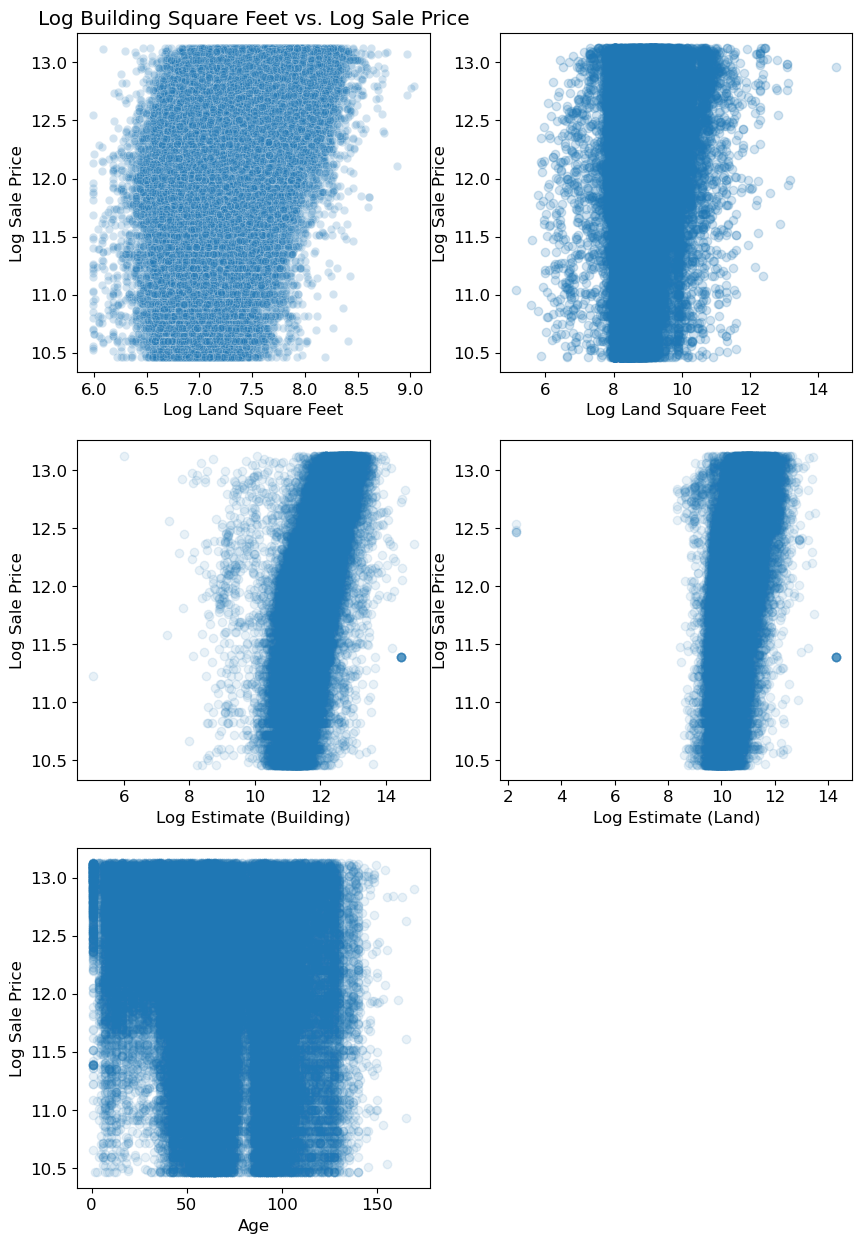

In [475]:
import seaborn as sns
import matplotlib.pyplot as plt

data_train = remove_outliers(data_train, variable='Sale Price',lower=np.percentile(data_train['Sale Price'], 25), upper=np.percentile(data_train['Sale Price'], 97))


# Create a figure and axis with a specific size
plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
# Create scatterplot using Seaborn
sns.scatterplot(x=np.log(data_train["Building Square Feet"] + 1), y=data_train["Log Sale Price"], alpha = 0.2)

# Customize the plot
plt.title('Log Building Square Feet vs. Log Sale Price')
plt.xlabel('Log Land Square Feet')
plt.ylabel('Log Sale Price')


plt.subplot(3, 2, 2)
plt.scatter(np.log(data_train["Land Square Feet"]+1), data_train["Log Sale Price"], alpha=0.2)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Land Square Feet")


plt.subplot(3, 2, 3)
# impute with mean
impute_estimate_building = np.mean(data_train["Estimate (Building)"]) 

data_train.loc[data_train["Estimate (Building)"]<1, "Estimate (Building)"] = np.mean(data_train["Estimate (Building)"])
plt.scatter(np.log(data_train["Estimate (Building)"]), data_train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Estimate (Building)")

plt.subplot(3, 2, 4)
impute_estimate_land = np.mean(data_train["Estimate (Land)"]) # save for later use
data_train.loc[data_train["Estimate (Land)"]<1, "Estimate (Land)"] = np.mean(data_train["Estimate (Land)"])
plt.scatter(np.log(data_train["Estimate (Land)"]), data_train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Estimate (Land)")

plt.subplot(3, 2, 5)
plt.subplot(3, 2, 5)
plt.scatter(data_train["Age"], data_train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Age");



# Show plot
plt.show()

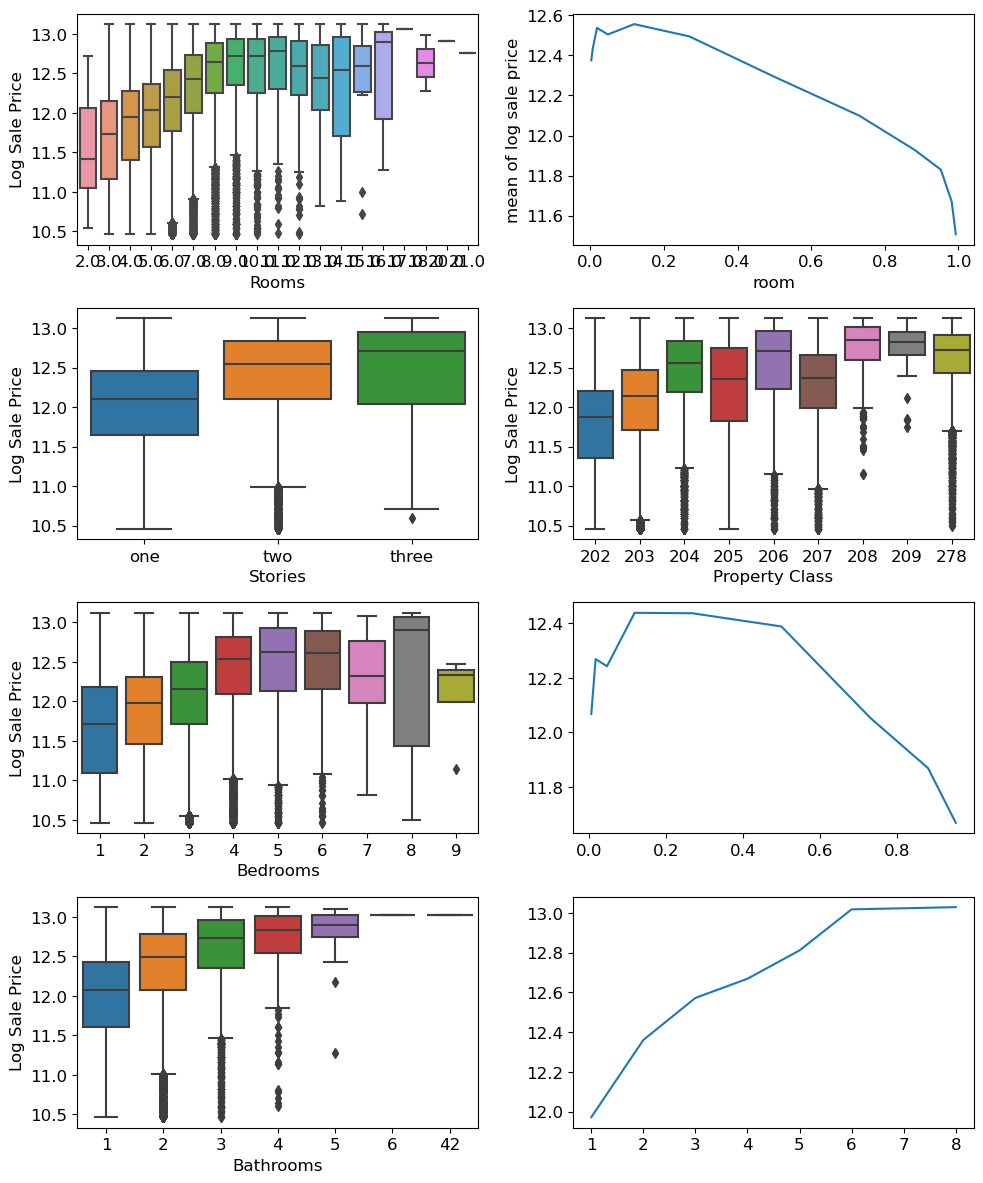

In [476]:
rooms_regex = r'has a total of (\d+) rooms'
data_train['Rooms'] = data_train['Description'].str.extract(rooms_regex).astype(float)
data_train['Rooms'] = data_train['Rooms']

plt.figure(figsize=(10, 12))
plt.subplot(4, 2, 1)
sns.boxplot(x='Rooms', y='Log Sale Price', data=data_train)


plt.subplot(4, 2, 2)
# not much change after 13, so cap it at 13
data_train['Rooms'] = np.clip(data_train['Rooms'], a_min=0, a_max=13)
data_room_1 = data_train[["Rooms", "Log Sale Price"]].groupby("Rooms").agg("mean")
data_room_2 = data_room_1[["Log Sale Price"]]

# This is sigmoid functon with centering first
room_shift = 7
data_room_1.index = 1/(1+np.exp(data_room_1.index-room_shift))
plt.plot(data_room_1.index, data_room_1)
plt.xlabel("room")
plt.ylabel("mean of log sale price")

# very little so one-hot encode is okay
data_train['Stories'] = data_train['Description'].str.extract(r'\s(\w+)-story')
plt.subplot(4, 2, 3)
# No transformation
sns.boxplot(x='Stories', y='Log Sale Price', data=data_train)


# another one-hot encode
plt.subplot(4, 2, 4)
sns.boxplot(x='Property Class', y='Log Sale Price', data=data_train)


data_train['Bedrooms'] = data_train['Description'].str.extract(r', (\d+) of which').astype(int)
plt.subplot(4, 2, 5)
sns.boxplot(x='Bedrooms', y='Log Sale Price', data=data_train)
data_bed = data_train[["Bedrooms", "Log Sale Price"]].groupby("Bedrooms").mean()[["Log Sale Price"]]


# This is sigmoid functon with centering first
bed_shift = 4
data_bed.index = 1/(1+np.exp(data_bed.index-bed_shift))
plt.subplot(4, 2, 6)
plt.plot(data_bed.index, data_bed)


data_train['Bathrooms'] = data_train['Description'].str.extract(r', and (\d+)').astype(int)
plt.subplot(4, 2, 7)
sns.boxplot(x='Bathrooms', y='Log Sale Price', data=data_train)
data_train["Bathrooms"] = np.clip(data_train["Bathrooms"], a_min=0, a_max=8)
data_bath = data_train[["Bathrooms", "Log Sale Price"]].groupby("Bathrooms").mean()[["Log Sale Price"]]
plt.subplot(4, 2, 8)
plt.plot(data_bath.index, data_bath)

plt.tight_layout()

In [477]:
transforms = {'log': np.log, 'square': np.square, 'cube': lambda x: x**3,'sqrt': np.sqrt, 'cubic root': lambda x: x**(1/3)}

cols = ["Age", "Fireplaces", "Land Square Feet", "Number of Commercial Units",
        "Road Proximity", "Bedrooms"]
corrs = []
for col in cols:
    for t in transforms:
        f = transforms[t]
        cor = np.corrcoef(f(data_train[col]), data_train['Log Sale Price'])[0, 1]
        corrs.append([col, t, cor])
        
sorted_list = sorted(corrs, key=lambda x: x[2])
sorted_list

[['Age', 'log', -0.19371606504565228],
 ['Age', 'cubic root', -0.19307234556258082],
 ['Age', 'sqrt', -0.18877164339889776],
 ['Age', 'square', -0.13224759384133947],
 ['Age', 'cube', -0.1041189223296959],
 ['Fireplaces', 'log', nan],
 ['Number of Commercial Units', 'cubic root', -0.0013139581800254074],
 ['Number of Commercial Units', 'sqrt', -0.0010898555194199353],
 ['Number of Commercial Units', 'square', 0.0008319326223751113],
 ['Number of Commercial Units', 'cube', 0.0010367838736063879],
 ['Land Square Feet', 'cube', 0.004563818129273016],
 ['Land Square Feet', 'square', 0.008391749237518563],
 ['Road Proximity', 'square', 0.015324845303485853],
 ['Road Proximity', 'cube', 0.015324845303485853],
 ['Road Proximity', 'sqrt', 0.015324845303485853],
 ['Road Proximity', 'cubic root', 0.015324845303485853],
 ['Land Square Feet', 'sqrt', 0.18899755811116042],
 ['Fireplaces', 'cube', 0.20101968249227162],
 ['Land Square Feet', 'cubic root', 0.20324572643690017],
 ['Land Square Feet', '

<br>

---

## Defining Helper Function or Helper Variables

In [478]:
x = data_train["Description"]
x.iloc[45]

'This property, sold on 01/23/2019, is a one-story with partially livable attics houeshold located at 5818 W 26TH ST.It has a total of 6 rooms, 3 of which are bedrooms, and 2.0 of which are bathrooms.'

In [480]:
# Define any additional helper functions or variables you need here

#Let's define a function which will extract all the rooms from the description, and add them to the existing table

def add_rooms_description(data):
    with_rooms_data = data.copy()
    extracting_rooms_regex = r'has a total of (\d+) rooms'
    bedrooms_regex = r'(\d+) of which are bedrooms'
    bathrooms_regex = r' (\d+\.\d+) of which are bathrooms'
    stories_regex = r' (\w+)-story'

    with_rooms_data["Rooms"] = with_rooms_data["Description"].str.extract(extracting_rooms_regex).astype("float")
    with_rooms_data["Bedrooms"] = with_rooms_data["Description"].str.extract(bedrooms_regex).astype("float")
    with_rooms_data["Bathrooms"] = with_rooms_data["Description"].str.extract(bathrooms_regex).astype("float")
    with_rooms_data["Stories"] = with_rooms_data["Description"].str.extract(stories_regex)
    return with_rooms_data


def one_hot_encode_column(data, columns_to_encode):
    #columns should be a list of the column names to one hot encode
        
    one_hot_object = OneHotEncoder()
    one_hot_object.fit(data[columns_to_encode])
    transformed = one_hot_object.transform(data[columns_to_encode])

    one_hot_dataframe = pd.DataFrame(transformed.toarray(), columns=one_hot_object.get_feature_names_out(), index = data.index)
    return data.join(one_hot_dataframe), one_hot_object.get_feature_names_out().tolist()

def sigmoid(s, center):
    return 1/(1+np.exp(s-center))

def bin_col(data, colname, granularity):
    """Puts a numerical column into categorical bins by granularity.
    Credit: Sherry Fan"""
    data = data.copy()
    min_val = min(data[colname])
    data[colname + " Bin"] = ((data[colname] - min_val)//granularity).astype(str)
    return data


def rank_neighborhoods_trans(data, metric=np.median):
    """
    Input: data (data frame): should contain at least a string-valued Neighborhood and a numeric 'Sale Price' column
    metric (function): function used for aggregating the data in each neighborhood. For example, np.median for median prices
    Output: Data with bin One Hot Encoded columns
    """
    data["Neighborhood Code map"] = data['Neighborhood Code'].replace(neighborhood_map)
    data = bin_col(data, "Neighborhood Code map", 6)
    data["Neighborhood Code map Bin"] = data["Neighborhood Code map Bin"].astype("int")
    
    #print(len(data["Town and Neighborhood map Bin"].value_counts()))
    data, ohe_cols_neighborhood = one_hot_encode_column(data, ["Neighborhood Code map Bin"])
    ohe_cols_neighborhood = ohe_cols_neighborhood
    possible = (neighborhood_map//6).unique()
    for n in possible:
        colname = "Neighborhood Code map Bin"+"_"+str(n)
        if colname not in data.columns:
            data[colname] = 0
            ohe_cols_neighborhood += [colname]
    data["Neighborhood Code map Bin"] = data["Neighborhood Code map Bin"].astype("int")**2
    return data, ohe_cols_neighborhood


32


<Axes: xlabel='Neighborhood Code map Bin', ylabel='Log Sale Price'>

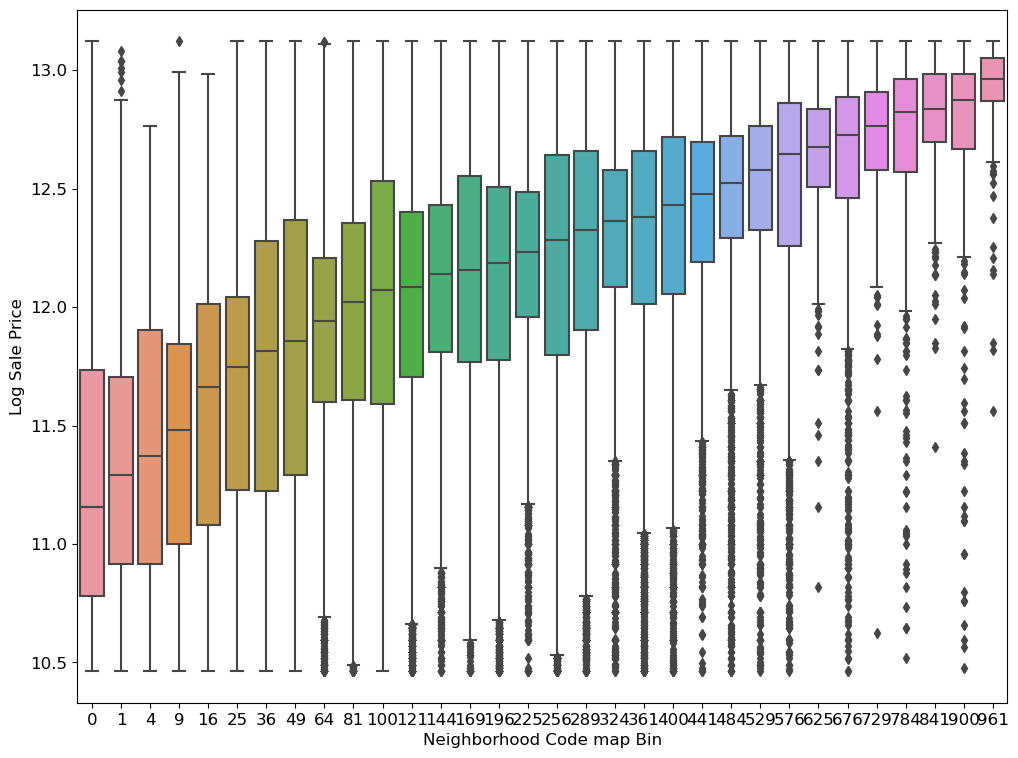

In [481]:
neighborhood_map_1 = data_train.groupby('Neighborhood Code', as_index=False).aggregate({'Log Sale Price':np.median}).sort_values(by='Log Sale Price', ignore_index=True)["Neighborhood Code"]
neighborhood_map_2 = pd.Series(neighborhood_map_1.index.values,index=neighborhood_map_1)
neighborhood_map = neighborhood_map_2.astype("int")
data_neighborhood, ohe_cols_neighborhood = rank_neighborhoods_trans(data_train,metric=np.median)
print(len(ohe_cols_neighborhood))
sns.boxplot(x='Neighborhood Code map Bin', y='Log Sale Price',data=data_neighborhood)

<br>

---

## Defining The Pipeline Function

Just as in the guided model from the previous question, we should encapsulate as much of your workflow into functions as possible. Our job is to select better features and define your own feature engineering pipeline inside the function `feature_engine_final` in the following cell. Use of `.pipe` is not required, but you are welcome to incorporate it!

- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`.

- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`.
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `Y` (the `Log Sale Price` column).

In [493]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
def feature_engine_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        
        #Get all Features in Data Frame
        
        #This is adopted from Sherry Fan
        
        data = remove_outliers(data, variable = "Sale Price", lower = np.percentile(data["Sale Price"], 25), upper = np.percentile(data["Sale Price"], 97))
        data['Log Sale Price'] = np.log(data['Sale Price'])
        
        data["Log Building Square Feet"] = np.log(data["Building Square Feet"]+1)
        data["Log Land Square Feet"] = np.log(data["Land Square Feet"]+1)
        data.loc[data["Estimate (Building)"]<1, "Estimate (Building)"] = impute_estimate_building
        data.loc[data["Estimate (Land)"]<1, "Estimate (Land)"] = impute_estimate_land
        
        data["Log Estimate (Building)"] = np.log(data["Estimate (Land)"])
        data["Log Estimate (Land)"] = np.log(data["Estimate (Land)"])
        
        data = add_rooms_description(data)
        data['Rooms'] = sigmoid(np.clip(data['Rooms'], a_min=0, a_max=13),room_shift)
        data['Bedrooms'] = sigmoid(np.clip(data["Bathrooms"], a_min=0, a_max=8),bed_shift)
        data['Bathrooms'] = np.clip(data["Bathrooms"], a_min=0, a_max=8)


        data, ohe_cols_prop = one_hot_encode_column(data, ["Property Class"])
        data, ohe_cols_fire = one_hot_encode_column(data, ["Fireplaces"])
        data, ohe_cols_neighborhood = rank_neighborhoods_trans(data, metric=np.median)
        data, ohe_cols_twon = one_hot_encode_column(data, ["Town Code"])
        

                
    else:
        data = remove_outliers(data, variable = "Sale Price", lower = np.percentile(data["Sale Price"], 10), upper = np.percentile(data["Sale Price"], 97))
        
        data["Log Building Square Feet"] = np.log(data["Building Square Feet"]+1)
        data["Log Land Square Feet"] = np.log(data["Land Square Feet"]+1)
        data.loc[data["Estimate (Building)"]<1, "Estimate (Building)"] = impute_estimate_building
        data.loc[data["Estimate (Land)"]<1, "Estimate (Land)"] = impute_estimate_land
        
        data["Log Estimate (Building)"] = np.log(data["Estimate (Land)"])
        data["Log Estimate (Land)"] = np.log(data["Estimate (Land)"])
        
        data = add_rooms_description(data)
        data['Rooms'] = sigmoid(np.clip(data['Rooms'], a_min=0, a_max=13),room_shift)
        data['Bedrooms'] = sigmoid(np.clip(data["Bathrooms"], a_min=0, a_max=8),bed_shift)
        data['Bathrooms'] = np.clip(data["Bathrooms"], a_min=0, a_max=8)


        data, ohe_cols_prop = one_hot_encode_column(data, ["Property Class"])
        data, ohe_cols_fire = one_hot_encode_column(data, ["Fireplaces"])
        data, ohe_cols_neighborhood = rank_neighborhoods_trans(data, metric=np.median)
        data, ohe_cols_twon = one_hot_encode_column(data, ["Town Code"])
        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    #data.drop(columns = ["Log Estimate (Land)", "Log Estimate (Building)", "Bathrooms", "Rooms"], axis = 1)

    features = (['Log Building Square Feet', 'Log Land Square Feet', 'Log Estimate (Land)', 'Log Estimate (Building)', 'Rooms', 'Bedrooms','Bathrooms']
                + ohe_cols_twon[:-1] 
                + ohe_cols_prop[:-1]
                + ohe_cols_fire[:-1]
                + ohe_cols_neighborhood[:-1])
    
    """ All features - a bank to find the best combinations
    
    features = (['Log Building Square Feet', 'Log Land Square Feet', 'Log Estimate (Land)', 'Log Estimate (Building)', 'Rooms', 'Bedrooms','Bathrooms']
                + ohe_cols_twon[:-1] 
                + ohe_cols_prop[:-1]
                + ohe_cols_neighborhood[:-1] 
                + ohe_cols_fire[:-1])"""
                
    
    

    #"Log Land Square Feet", "Log Building Square Feet"
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        X = data[features]
        X = X.fillna(0)
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = data[features]
        X = X.fillna(0)
        # Response variable
        Y = data["Log Sale Price"]
        
        return X, Y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), feature_engine_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 103169.5274184191


<br>

---

## Fitting and Evaluating our Model

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

A function that computes the RMSE is provided below. Feel free to use it if you would like calculate the RMSE for your training set.

In [494]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

### Using our pipeline function to add our features all in one go

In [495]:
train_feature_matrix, train_observed_log_sale = feature_engine_final(data_train)
val_feature_matrix, val_observed_log_sale = feature_engine_final(data_val)

# Keep only the columns in val_feature_matrix that are also in train_feature_matrix, just to avoid errors with the Linear Model
val_feature_matrix = val_feature_matrix.reindex(columns=train_feature_matrix.columns)

#### Fitting our Model

In [496]:
custom_linear_model = lm.LinearRegression(fit_intercept=True)
custom_linear_model.fit(train_feature_matrix, train_observed_log_sale)


train_predicted = custom_linear_model.predict(train_feature_matrix)
val_predicted = custom_linear_model.predict(val_feature_matrix)

#### Calculating the RMSE for the Training and Validation Sets

In [497]:
print(f' Our Training RMSE is ${rmse(np.exp(train_predicted), np.exp(train_observed_log_sale))}')
print(f' Our Validation RMSE is ${(rmse(np.exp(val_predicted), np.exp(val_observed_log_sale)))}')

 Our Training RMSE is $60592.15277150539
 Our Validation RMSE is $125526.35915697776


#### K-Fold Cross Validation

In [498]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error


def rmse_exp(y_true, y_pred):
    y_true_exp = np.exp(y_true)
    y_pred_exp = np.exp(y_pred)
    return np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))


rmse_exp_scorer = make_scorer(rmse_exp, greater_is_better=False)

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Use negative MSE because cross_val_score maximizes the score, and we need to minimize MSE
rmse_scores = cross_val_score(custom_linear_model, val_feature_matrix, val_observed_log_sale, scoring=rmse_exp_scorer, cv=kf)

# Take the negative of the scores to get positive MSE values
rmse_scores = -rmse_scores

# Calculate the average MSE across all folds
average_mse = np.mean(rmse_scores)
print(f"Root Mean Squared Error across {k} folds: {average_mse}")

Root Mean Squared Error across 5 folds: 102867.7535574029
